# Audio Sensor Test

First import some libraries that are used and then query the audio devices available

In [1]:
# Import libraries
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

print(sd.query_devices())

fs = 48000  # sampling rate
seconds = 6  # duration 

   0 rockchip-dp0: spdif-hifi-0 (hw:0,0), ALSA (0 in, 2 out)
   1 rockchip-hdmi0: i2s-hifi-0 (hw:1,0), ALSA (0 in, 2 out)
   2 rockchip-es8388: dailink-multicodecs ES8323.6-0010-0 (hw:2,0), ALSA (2 in, 2 out)
   3 AudioHubNano2D_V1.5: USB Audio (hw:3,0), ALSA (2 in, 0 out)
   4 sysdefault, ALSA (0 in, 128 out)
   5 samplerate, ALSA (0 in, 128 out)
   6 speexrate, ALSA (0 in, 128 out)
   7 pulse, ALSA (32 in, 32 out)
   8 upmix, ALSA (0 in, 8 out)
   9 vdownmix, ALSA (0 in, 6 out)
  10 dmix, ALSA (0 in, 2 out)
* 11 default, ALSA (32 in, 32 out)


Now record some audio and save to file

In [10]:
from scipy.io.wavfile import write

sd.default.device = 3 # Set device

# Record audio
print("Recording...")
myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2, dtype='float64')
sd.wait()  # Wait for the recording to finish
print("Recording complete")

# Ignore the first second of the recording (fs * 1 second to skip)
myrecording = myrecording[int(fs*1):, :] 
myrecording_normalised = myrecording / np.max(np.abs(myrecording))

# Save the recording as a wav file
print("Writing wav...")
write('output.wav', fs, myrecording)  
print("Writing wav complete")

Recording...
Recording complete
Writing wav...
Writing wav complete


Read in some audio (if required) and play

In [19]:
from scipy.io.wavfile import read

# file_name = 'output_env.wav'
# file_name = 'output_click.wav'
file_name = 'output.wav'
fs, myrecording = read(file_name)
myrecording_normalised = myrecording / np.max(np.abs(myrecording))
print('Sample rate:', fs)

# Switch to default output device
sd.default.device = 11

# Play the recorded sound
print("Playing recorded sound...")
sd.play(myrecording_normalised, fs)
sd.wait()  # Wait for the audio to finish playing
print("Playback complete")

Sample rate: 48000
Playing recorded sound...
Playback complete


Plot in time and time/frequency

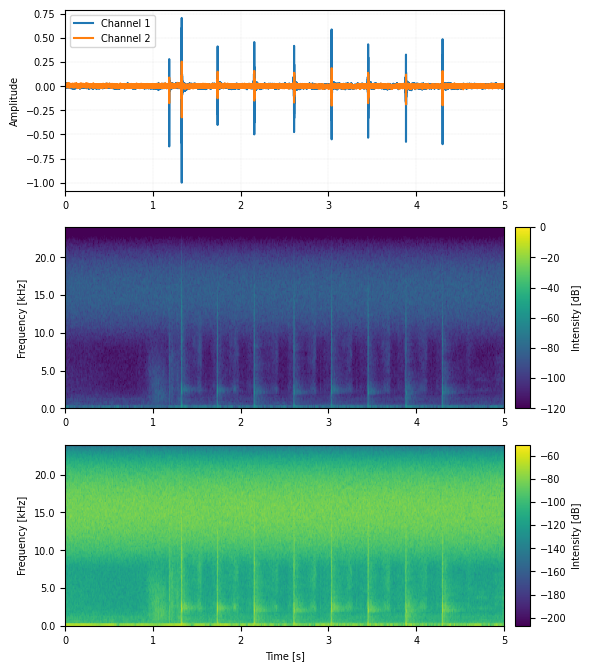

In [32]:
from matplotlib.ticker import FixedLocator

# Define the grid layout
fig = plt.figure(figsize=(6, 8))
gs = gridspec.GridSpec(3, 2, width_ratios=[6, 0.2], wspace=0.05)

# Create the time-domain plot
time = np.linspace(0., seconds-1, myrecording.shape[0])  # subtract one to account for the ignored second
ax0 = plt.subplot(gs[0, 0])
ax0.plot(time, myrecording_normalised[:, 0], label="Channel 1")  
ax0.plot(time, myrecording_normalised[:, 1], label="Channel 2")  
ax0.legend(fontsize=7)
ax0.set_ylabel("Amplitude", fontsize=7)
ax0.tick_params(labelsize=7)  
ax0.set_xlim([0, seconds-1]) 
ax0.grid(True, linestyle='-.', linewidth=0.1)  # Add a grid
 
# Create spectrogram for Channel 1
ax1 = plt.subplot(gs[1, 0])
cax1 = ax1.specgram(myrecording_normalised[:, 0], Fs=fs, mode='psd', window=None, vmin=-120, vmax=0)  # Set vmin and vmax
ax1.set_xlim([0, seconds-1])  # Set x-axis limits
ax1.set_ylabel('Frequency [kHz]', fontsize=7)
ax1.tick_params(labelsize=7) 
img1 = cax1[3]  
cbar1 = plt.colorbar(cax1[3], cax=plt.subplot(gs[1, 1]), label='Intensity [dB]')
cbar1.ax.tick_params(labelsize=7) 
cbar1.set_label('Intensity [dB]', size=7)  
ylocs = ax1.get_yticks()
ax1.yaxis.set_major_locator(FixedLocator(ylocs))
ax1.set_yticklabels(['%1.1f' % (y / 1000) for y in ylocs])

# Create spectrogram for Channel 2
ax2 = plt.subplot(gs[2, 0])
cax2 = ax2.specgram(myrecording_normalised[:, 1], Fs=fs, mode='psd')
ax2.set_xlim([0, seconds-1])  # Set x-axis limits
ax2.set_xlabel('Time [s]', fontsize=7)
ax2.set_ylabel('Frequency [kHz]', fontsize=7)
ax2.tick_params(labelsize=7)  
img2 = cax2[3]  #
# img2.set_clim(vmin=-120, vmax=0)  # set limits in dB
cbar2 = plt.colorbar(cax2[3], cax=plt.subplot(gs[2, 1]), label='Intensity [dB]')
cbar2.ax.tick_params(labelsize=7)  
cbar2.set_label('Intensity [dB]', size=7)  
ylocs = ax2.get_yticks()
ax2.yaxis.set_major_locator(FixedLocator(ylocs))
ax2.set_yticklabels(['%1.1f' % (y / 1000) for y in ylocs])

plt.show()


Cross correlation

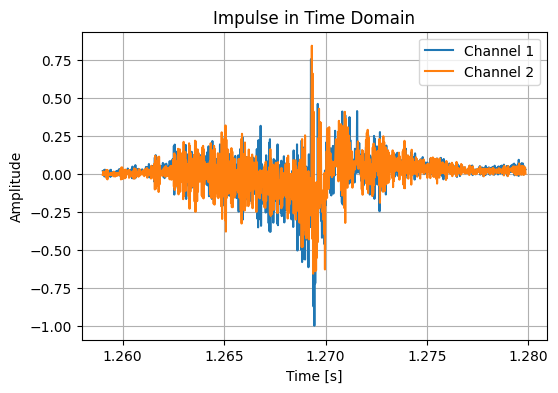

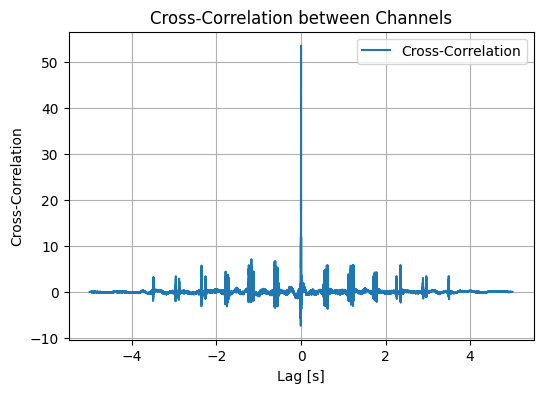

Delay: 2.0833333333333333e-05 seconds
Spatial Nyquist frequency: 7999.067164179104 Hz
Angle of Arrival: 19.46885858114507 degrees


In [7]:
from scipy import signal

channel_1 = myrecording_normalised[:, 0]
channel_2 = myrecording_normalised[:, 1]

# find the sample with the maximum absolute value
impulse_index = np.argmax(np.abs(channel_1))

# extract a window of 1000 samples around the impulse
window_size = 1000
impulse_L = channel_1[impulse_index-window_size//2 : impulse_index+window_size//2]
impulse_R = channel_2[impulse_index-window_size//2 : impulse_index+window_size//2]
impulse_time = np.linspace((impulse_index-window_size//2)/fs, (impulse_index+window_size//2)/fs, window_size)

# Plot the impulse
plt.figure(figsize=(6, 4))
plt.plot(impulse_time, impulse_L, label="Channel 1")  
plt.plot(impulse_time, impulse_R, label="Channel 2")  
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Impulse in Time Domain")
plt.grid(True)
plt.legend()
plt.show()

# Compute the cross-correlation
corr = signal.correlate(channel_1, channel_2, mode='full', method='auto')

# Create an array representing the lag times
lags = signal.correlation_lags(len(channel_1), len(channel_2), mode='full')
lag_time = lags / fs # Convert lags to time

# Plot the cross-correlation
plt.figure(figsize=(6, 4))
plt.plot(lag_time, corr, label="Cross-Correlation")
plt.xlabel("Lag [s]")
plt.ylabel("Cross-Correlation")
plt.title("Cross-Correlation between Channels")
plt.grid(True)
plt.legend()
plt.show()

# Find the delay
delay_samples = corr.argmax() - (len(channel_1) - 1)
delay_seconds = delay_samples / fs

print(f"Delay: {delay_seconds} seconds")

d = 2.144 / 100 # distance between the microphones in meters
speed_of_sound = 343  # speed of sound in m/s
angle_of_arrival = np.arcsin(delay_seconds * speed_of_sound / d)
f_Nyquist = speed_of_sound / (2 * d) 
print(f"Spatial Nyquist frequency: {f_Nyquist} Hz")
print(f"Angle of Arrival: {np.degrees(angle_of_arrival)} degrees")